In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Found 6269 images belonging to 10 classes.
Found 1322 images belonging to 10 classes.
Found 1364 images belonging to 10 classes.
Epoch 1/50
195/195 [==============================] - 186s 677ms/step - loss: 2.2653 - accuracy: 0.1910 - val_loss: 2.3401 - val_accuracy: 0.1166
Epoch 2/50
195/195 [==============================] - 127s 650ms/step - loss: 2.1915 - accuracy: 0.2176 - val_loss: 2.9152 - val_accuracy: 0.1677
Epoch 3/50
195/195 [==============================] - 127s 649ms/step - loss: 2.1510 - accuracy: 0.2322 - val_loss: 2.3790 - val_accuracy: 0.1890
Epoch 4/50
195/195 [==============================] - 128s 656ms/step - loss: 2.0902 - accuracy: 0.2490 - val_loss: 5.6034 - val_accuracy: 0.2134
Epoch 5/50
195/195 [==============================] - 127s 649ms/step - loss: 2.0792 - accuracy: 0.2522 - val_loss: 2.2746 - val_accuracy: 0.2127
Epoch 6/50
195/195 [==============================] - 127s 652ms/step - loss: 2.0462 - accuracy: 0.2620 - val_loss: 5.7378 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


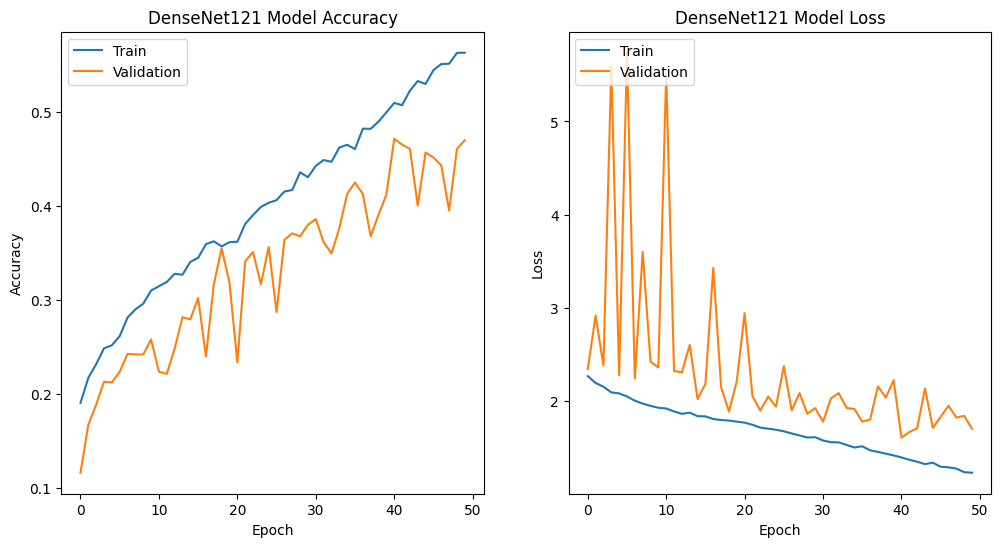

43/43 [==============================] - 6s 141ms/step
DenseNet121 - Test Accuracy: 0.4702380895614624
DenseNet121 - Test mAP: 0.5387324002525608


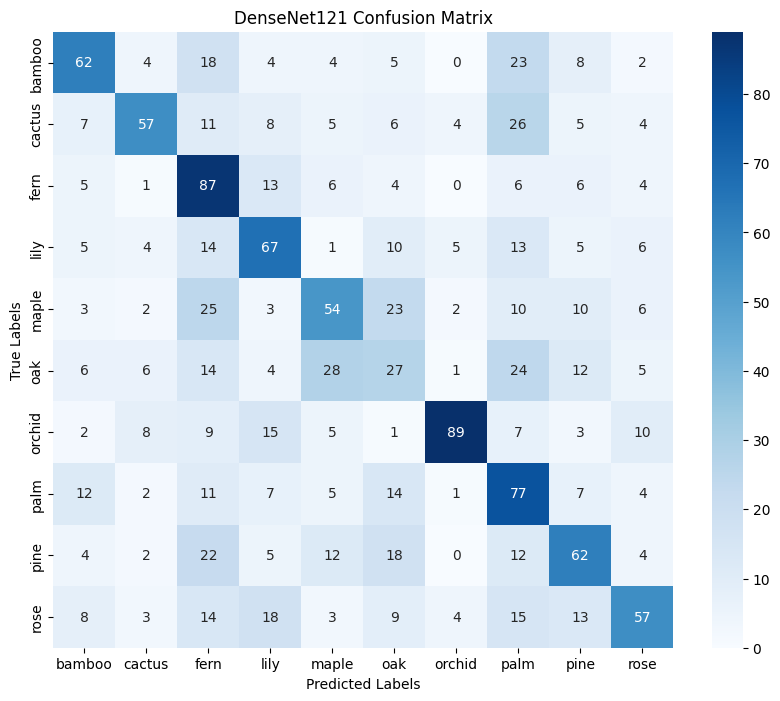

Classification Report for DenseNet121:
              precision    recall  f1-score   support

      bamboo       0.54      0.48      0.51       130
      cactus       0.64      0.43      0.51       133
        fern       0.39      0.66      0.49       132
        lily       0.47      0.52      0.49       130
       maple       0.44      0.39      0.41       138
         oak       0.23      0.21      0.22       127
      orchid       0.84      0.60      0.70       149
        palm       0.36      0.55      0.44       140
        pine       0.47      0.44      0.46       141
        rose       0.56      0.40      0.46       144

    accuracy                           0.47      1364
   macro avg       0.49      0.47      0.47      1364
weighted avg       0.50      0.47      0.47      1364



In [ ]:
import warnings
import re
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image
import seaborn as sns

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Palette images with Transparency")

# Escape special characters in the PyDataset warning message
pydataset_warning_message = r"Your `PyDataset` class should call `super\(\)\.__init__\(\*\*kwargs\)` in its constructor"
warnings.filterwarnings("ignore", category=UserWarning, message=re.escape(pydataset_warning_message))

# Define function to calculate mAP (mean Average Precision)
def calculate_mAP(y_true, y_pred):
    mAP = []
    for i in range(len(y_true[0])):
        mAP.append(average_precision_score(y_true[:, i], y_pred[:, i]))
    return np.mean(mAP)

# Define paths to your dataset directories
train_data_dir = '/content/drive/My Drive/Colab Notebooks/plant_subspecies_split/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/plant_subspecies_split/val'
test_data_dir = '/content/drive/My Drive/Colab Notebooks/plant_subspecies_split/test'

# Function to remove corrupted images
def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)

# Remove corrupted images
remove_corrupted_images(train_data_dir)
remove_corrupted_images(validation_data_dir)
remove_corrupted_images(test_data_dir)

# Enhanced ImageDataGenerator class
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        gen = super().flow_from_directory(*args, **kwargs)
        self.samples = gen.samples
        self.num_classes = gen.num_classes
        return gen

# Define image data generators
train_datagen = CustomImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = CustomImageDataGenerator(rescale=1./255)
test_datagen = CustomImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Number of classes in your dataset
num_classes = train_generator.num_classes

# Build and compile DenseNet121 model
model_densenet121 = DenseNet121(weights=None, include_top=True, input_shape=(224, 224, 3), classes=num_classes)
model_densenet121.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model for 50 epochs
start_time = time.time()
history_densenet121 = model_densenet121.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,  # Train for 50 epochs as per instructions
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // 32
)
training_time_densenet121 = time.time() - start_time

# Evaluate the model on validation set
val_loss, val_accuracy = model_densenet121.evaluate(valid_generator, steps=valid_generator.samples // 32)

# Calculate mAP on the validation set
valid_generator.reset()
val_predictions = model_densenet121.predict(valid_generator, steps=valid_generator.samples // 32 + 1)
val_true = valid_generator.classes[:len(val_predictions)]
val_true = tf.keras.utils.to_categorical(val_true, num_classes=num_classes)
val_mAP = calculate_mAP(val_true, val_predictions)

print(f'DenseNet121 - Validation Accuracy: {val_accuracy}')
print(f'DenseNet121 - Validation mAP: {val_mAP}')
print(f'DenseNet121 - Training Time: {training_time_densenet121}')

# Save the trained model
model_densenet121.save('/content/drive/My Drive/Colab Notebooks/plant_subspecies_split/DenseNet121_plant_subspecies.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_densenet121.history['accuracy'])
plt.plot(history_densenet121.history['val_accuracy'])
plt.title('DenseNet121 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_densenet121.history['loss'])
plt.plot(history_densenet121.history['val_loss'])
plt.title('DenseNet121 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model_densenet121.evaluate(test_generator, steps=test_generator.samples // 32)

# Calculate mAP on the test set
test_generator.reset()
test_predictions = model_densenet121.predict(test_generator, steps=test_generator.samples // 32 + 1)
test_true = test_generator.classes[:len(test_predictions)]
test_true = tf.keras.utils.to_categorical(test_true, num_classes=num_classes)
test_mAP = calculate_mAP(test_true, test_predictions)

print(f'DenseNet121 - Test Accuracy: {test_accuracy}')
print(f'DenseNet121 - Test mAP: {test_mAP}')

# Confusion Matrix
test_predictions_classes = np.argmax(test_predictions, axis=1)
conf_matrix = confusion_matrix(test_generator.classes, test_predictions_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('DenseNet121 Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification Report
class_labels = list(test_generator.class_indices.keys())
class_report = classification_report(test_generator.classes, test_predictions_classes, target_names=list(test_generator.class_indices.keys()))
print('Classification Report for DenseNet121:')
print(class_report)
